In [55]:
import boto3
import pandas as pd
import json


In [56]:
s3 = boto3.client('s3')
bucket_name = 'iot-traffic-dataset'
data_key = 'athena-results-bucket/CSV results/traffic-cleaned-data.csv'

In [57]:
obj = s3.get_object(Bucket=bucket_name, Key=data_key)
df = pd.read_csv(obj['Body'])

In [58]:
df.head

<bound method NDFrame.head of      traffic_light_id                 datetime  vehicle_count  average_speed  \
0              TL-195  2024-11-19 18:52:49.000             51           46.9   
1              TL-102  2024-11-19 18:49:37.000             63           32.2   
2              TL-193  2024-11-19 18:49:45.000             59           11.4   
3              TL-196  2024-11-19 18:43:04.000             53           40.4   
4              TL-190  2024-11-19 18:44:12.000             59           30.5   
...               ...                      ...            ...            ...   
1010           TL-130  2024-11-19 18:54:18.000             48           42.6   
1011           TL-166  2024-11-19 18:48:24.000             55           10.1   
1012           TL-174  2024-11-19 18:38:20.000             69           39.4   
1013           TL-162  2024-11-19 18:53:39.000             48           19.3   
1014           TL-137  2024-11-19 18:49:10.000             52           26.1   

      co2

In [59]:
# Display data types and basic statistics
print(df.info())
print(df.describe())

# Check for missing values
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1015 entries, 0 to 1014
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   traffic_light_id          1015 non-null   object 
 1   datetime                  1015 non-null   object 
 2   vehicle_count             1015 non-null   int64  
 3   average_speed             1015 non-null   float64
 4   co2_level                 1015 non-null   float64
 5   temperature               1015 non-null   float64
 6   humidity                  1015 non-null   float64
 7   congestion_level_encoded  1015 non-null   int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 63.6+ KB
None
       vehicle_count  average_speed    co2_level  temperature     humidity  \
count    1015.000000    1015.000000  1015.000000  1015.000000  1015.000000   
mean       50.226601      30.608867     0.050045    27.323842    59.485517   
std        15.183879      10.073699     0.

In [60]:
df['traffic_density'] = df['vehicle_count'] / df['average_speed']
df.head(5)

,traffic_light_id,datetime,vehicle_count,average_speed,co2_level,temperature,humidity,congestion_level_encoded,traffic_density
0,TL-195,2024-11-19 18:52:49.000,51,46.9,0.0502,31.6,56.7,1,1.087420
1,TL-102,2024-11-19 18:49:37.000,63,32.2,0.0526,23.9,78.8,1,1.956522
2,TL-193,2024-11-19 18:49:45.000,59,11.4,0.0518,28.2,61.0,1,5.175439
3,TL-196,2024-11-19 18:43:04.000,53,40.4,0.0506,24.2,44.7,1,1.311881
4,TL-190,2024-11-19 18:44:12.000,59,30.5,0.0518,34.9,61.6,1,1.934426


/tmp/ipykernel_7436/3905505337.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='coolwarm')


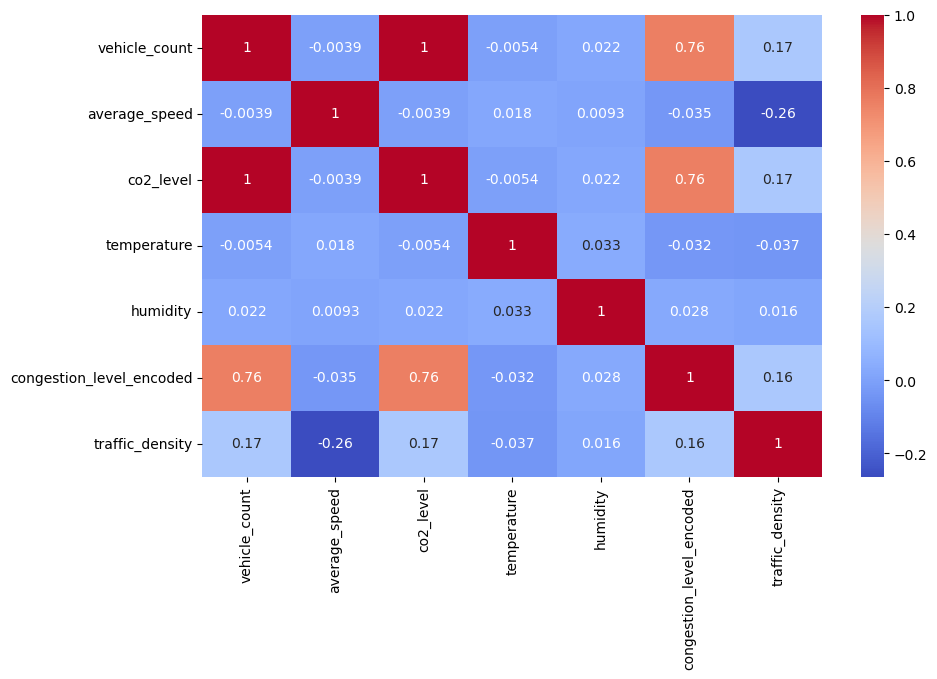

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()


In [100]:
from sklearn.model_selection import train_test_split

# Define features and target
x = df[['traffic_density', 'co2_level', 'temperature', 'humidity']]
y = df['congestion_level_encoded'].astype(int)

# Split data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [103]:
print("Length of X:", len(y_pred))
print("Length of y:", len(y_test))



Length of X: 203
Length of y: 203


In [102]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Evaluate the model
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Random Forest Accuracy: 1.00
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00       169
           2       1.00      1.00      1.00        19

    accuracy                           1.00       203
   macro avg       1.00      1.00      1.00       203
weighted avg       1.00      1.00      1.00       203



Random Forest Accuracy: 1.00
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00       169
           2       1.00      1.00      1.00        19

    accuracy                           1.00       203
   macro avg       1.00      1.00      1.00       203
weighted avg       1.00      1.00      1.00       203



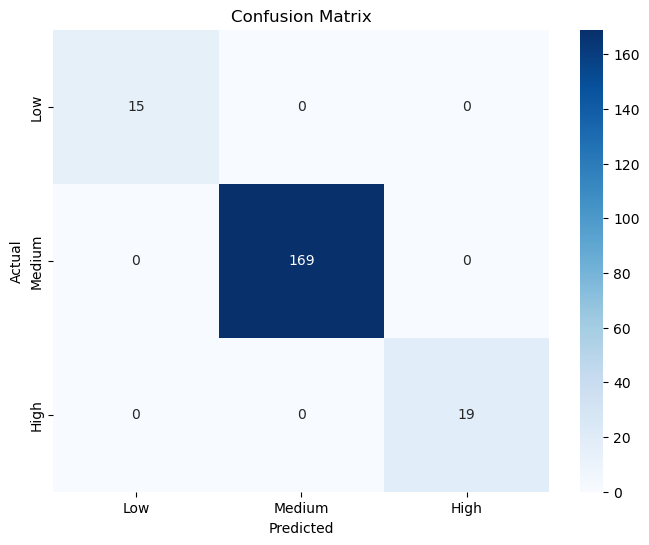

In [104]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions
y_pred = rf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.2f}")

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


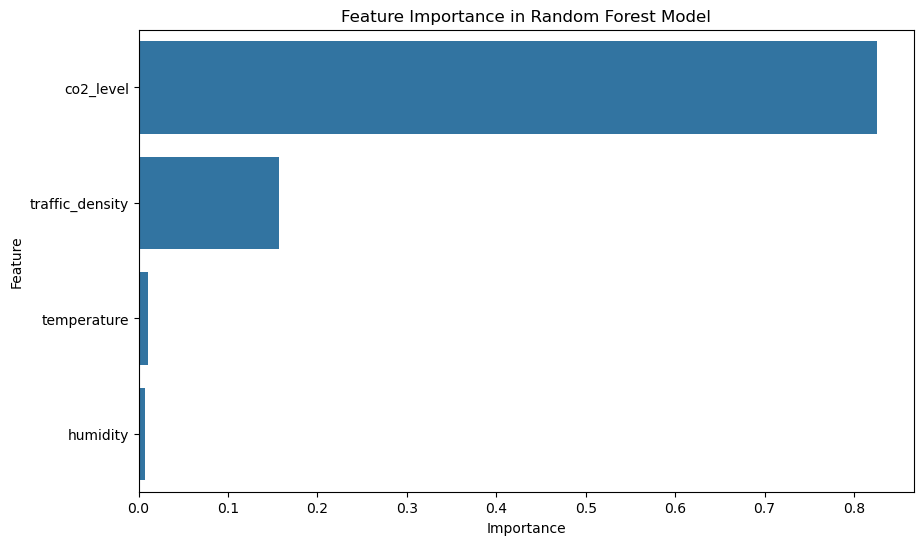

In [107]:
# Feature importance
importances = rf.feature_importances_
feature_names = X.columns

# Display feature importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Feature Importance in Random Forest Model")
plt.show()


In [109]:
import joblib
import boto3

joblib.dump(rf, 'model.joblib')

# Upload to S3
s3 = boto3.client('s3')
s3.upload_file('model.joblib', 'iot-traffic-dataset', 'model/model.joblib')
